In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [2]:
import sys
sys.path.append('..')
from transformers import AutoModelForSequenceClassification, AutoModelForCausalLM
from modeling_rmt import RMTDecoderForCausalLM
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from modeling_rmt import RMTEncoderForSequenceClassification
# from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

In [3]:
num_segments = 1
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'

In [4]:
model_name = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': num_mem_tokens, 
                'max_n_segments': num_segments,
                'tokenizer': tokenizer,
               #  'memory_layers': 'all', 
               #  'share_memory_layers': True,
               #  'reconstruction_loss_coef': 0.1,
                'segment_ordering': 'regular',
                'input_size': 1024, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

base_model = AutoModelForCausalLM.from_pretrained(model_name)
# rmt = RMTDecoderForCausalLM(base_model, **rmt_config)


# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt = RMTEncoderHorizontalMemory(base_model, **rmt_config)
# rmt.to(device)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


In [5]:
# input_ids = tokenizer.batch_encode_plus(['one two three'], return_tensors='pt')
input_ids = tokenizer.batch_encode_plus(['Hamlet is written by William'], return_tensors='pt')

In [6]:
generated = base_model.generate(**input_ids)
generated

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[21281,  1616,   318,  3194,   416,  3977,   367,    13,   367,  1940,
          1531,    11,  7504,    13,   290,   318,  3199,   416, 14534,  2097]])

In [7]:
tokenizer.decode(generated[0])

'Hamlet is written by William H. Haldane, Jr. and is published by Random House'

In [8]:
num_mem_tokens = 10
extended_vocab_size = base_model.config.vocab_size + num_mem_tokens
base_model.resize_token_embeddings(extended_vocab_size)

Embedding(50267, 768)

In [9]:
# generated = base_model.generate(**input_ids)
# generated

In [10]:
# tokenizer.decode(generated[0])

In [14]:
embeddings = base_model.get_input_embeddings()
embeddings.weight.data[-num_mem_tokens:] = embeddings.weight.data[-num_mem_tokens:].normal_(mean=0.0, std=embeddings.weight.data.std()) / 100 + embeddings.weight.data[tokenizer.encode('.')[0]]
base_model.set_input_embeddings(embeddings)


In [15]:
generated = base_model.generate(**input_ids)
generated

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[21281,  1616,   318,  3194,   416,  3977,   367, 50258,   367,  1940,
          1531,    11,  7504, 50264,   290,   318,  3199,   416, 14534,  2097]])

In [16]:
tokenizer.decode(generated[0])

'Hamlet is written by William H Haldane, Jr and is published by Random House'

In [56]:
# (embeddings.weight.data[tokenizer.eos_token_id] - embeddings.weight.data[-1]).mean()
(embeddings.weight.data[13] - embeddings.weight.data[-1]).mean()

tensor(-2.0668e-05)

In [62]:
embeddings = base_model.get_input_embeddings()
embeddings.weight.data[-num_mem_tokens:] = embeddings.weight.data[-num_mem_tokens:].normal_(mean=0.0, std=embeddings.weight.data.std()) / 9 + embeddings.weight.data[tokenizer.eos_token_id]
base_model.set_input_embeddings(embeddings)


In [63]:
generated = base_model.generate(**input_ids)
generated

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[  505,   734,  1115,  1440,  1936,  2237,  3598,  3624,  5193,  3478,
         22216, 14104, 28306, 29167, 17280, 27913, 38741, 29095, 29666, 29112]])

In [64]:
tokenizer.decode(generated[0])

'one two three four five six seven eight nine ten eleven twelve thirteen fourteen fifteen sixteen seventeen eighteen nineteenth twentieth'

In [43]:
embeddings = base_model.get_input_embeddings()
embeddings.weight.data[-num_mem_tokens:] = embeddings.weight.data[-num_mem_tokens:].normal_(mean=0.0, std=embeddings.weight.data.std()) / 2
base_model.set_input_embeddings(embeddings)


In [44]:
generated = base_model.generate(**input_ids)
generated

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[  505,   734,  1115, 50263, 50263, 50263, 50263, 50263, 50263, 50263,
         50263, 50263, 50263, 50263, 50263, 50263, 50263, 50263, 50263, 50263]])

In [45]:
tokenizer.decode(generated[0])

'one two three'

In [31]:
tokenizer.eos_token_id

50256

In [ ]:
# embeddings.weight.data[-num_mem_tokens:] = embeddings.weight.data[-num_mem_tokens:].normal_(mean=0.0, std=23.19373) / 2 + embeddings.weight.data[tokenizer.eos_token_id]


In [5]:
cpt = torch.load('../../runs/test/wikitext-2-v1/gpt2/lr5e-06_constant_with_warmup_adamw_wd1e-03_1004-1024-1x1024_mem10rw_bs32_iters25000_regular/run_1/model_best.pth', map_location='cpu')

In [6]:
# cpt['model_state_dict'].keys()

In [35]:
rmt.load_state_dict(cpt['model_state_dict'])

<All keys matched successfully>

In [8]:
# out = rmt(sample_input_ids, **kwargs, output_hidden_states=False, output_attentions=False)
# out.keys()

### load dataset 

In [9]:
class Holder:
    def __init__(self):
        pass

In [10]:
input_seq_len = 1004
target_seq_len = 1024
batch_size = 1

args = Holder
args.batch_size = batch_size
args.num_mem_tokens = 10
args.max_n_segments = 1
args.input_size = 1024
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [11]:
from lm_experiments_tools.lm_datasets import get_lm_datasets
from transformers import default_data_collator

raw_datasets = datasets.load_dataset('wikitext', 'wikitext-2-v1')
train_dataset, valid_dataset = get_lm_datasets(raw_datasets, tokenizer, block_size=args.input_seq_len)


# dataloader for RMT
# batch sample i is a continuation of sample i of the previous batch
class alignedDataLoader(DataLoader):
    def __iter__(self):
        all_inds = np.arange(len(self.dataset) // self.batch_size * batch_size)
        all_inds = all_inds.reshape(batch_size, -1)
        for batch_ind in range(all_inds.shape[1]):
            batch = [self.dataset[int(ind)] for ind in all_inds[:, batch_ind]]
            yield self.collate_fn(batch)


# shuffle train data each epoch (one loop over train_dataset)
# train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False,
#                                     drop_last=True, seed=args.seed)
# per_worker_batch_size = args.batch_size * args.gradient_accumulation_steps
# global_batch_size = per_worker_batch_size * hvd.size()
kwargs = {'pin_memory': True, 'num_workers': 1}
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size,# sampler=train_sampler,
                                collate_fn=default_data_collator, **kwargs)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
2023-03-16 16:26:08,354 - datasets.builder - WARNING - Reusing dataset wikitext (/home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

2023-03-16 16:26:08,471 - datasets.arrow_dataset - WARNING - Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-8be6e4468e749f78.arrow
2023-03-16 16:26:08,507 - datasets.arrow_dataset - WARNING - Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-536ebca993c930f8.arrow
2023-03-16 16:26:08,574 - datasets.arrow_dataset - WARNING - Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126/cache-ae92410a4d5f252a.arrow
2023-03-16 16:26:08,590 - datasets.arrow_dataset - WARNING - Loading cached processed dataset at /home/bulatov/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb1

In [29]:
gen = iter(train_dataloader)
batch = next(gen)


In [30]:
input_ids = batch.pop('input_ids')
out = rmt(input_ids, **batch, output_attentions = True)

In [31]:
out['loss']

tensor(115.7096, grad_fn=<NllLossBackward>)

In [16]:
segmented = rmt.pad_and_segment(input_ids)

In [34]:
base_out = rmt.model(input_ids, **batch)
base_out.loss

tensor(107.0328, grad_fn=<NllLossBackward>)

In [36]:
# trained
base_out = rmt.model(input_ids, **batch)
base_out.loss

tensor(2.5248, grad_fn=<NllLossBackward>)

In [37]:
rmt.model.resize_token_embeddings(rmt.model.config.vocab_size + 10)

Embedding(50277, 768)

In [39]:
rmt.model.resize_token_embeddings(rmt.model.config.vocab_size + 10)

Embedding(50287, 768)

In [40]:
# trained resized
base_out = rmt.model(input_ids, **batch)
base_out.loss

tensor(2.5336, grad_fn=<NllLossBackward>)

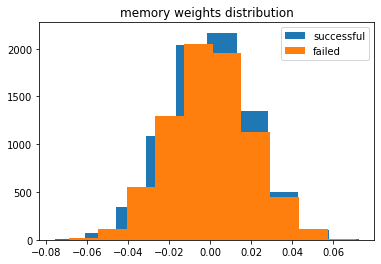

In [74]:
## memory weights
memory1 = rmt1.set_memory((1, 512))
memory2 = rmt2.set_memory((1, 512))

plt.title('memory weights distribution')
plt.hist(memory1.flatten().detach())
plt.hist(memory2.flatten().detach())

plt.legend(['successful', 'failed'])
plt.show()

### plot attentions


In [63]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, y_tokens=None, p_attentions=None, filename='att.png', save=False, size=None):
    # attentions n_layers x n_heads x len x len
    attention = attentions.detach()
    if size is not None:
        sz = size
    else:
        sz = max(*attention.shape) // 3
    fig = plt.figure(figsize=(sz, sz))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(sz, 3*sz))
    y_tokens = y_tokens[:attention.shape[1]]
    tokens = tokens[:attention.shape[2]]    

    
    # if p_attentions:
    #     p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            # print('y_tokens', len(y_tokens), y_tokens)
            ax.set_yticklabels(y_tokens)#, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [64]:
segmented = rmt.pad_and_segment(input_ids)

<Figure size 720x720 with 0 Axes>

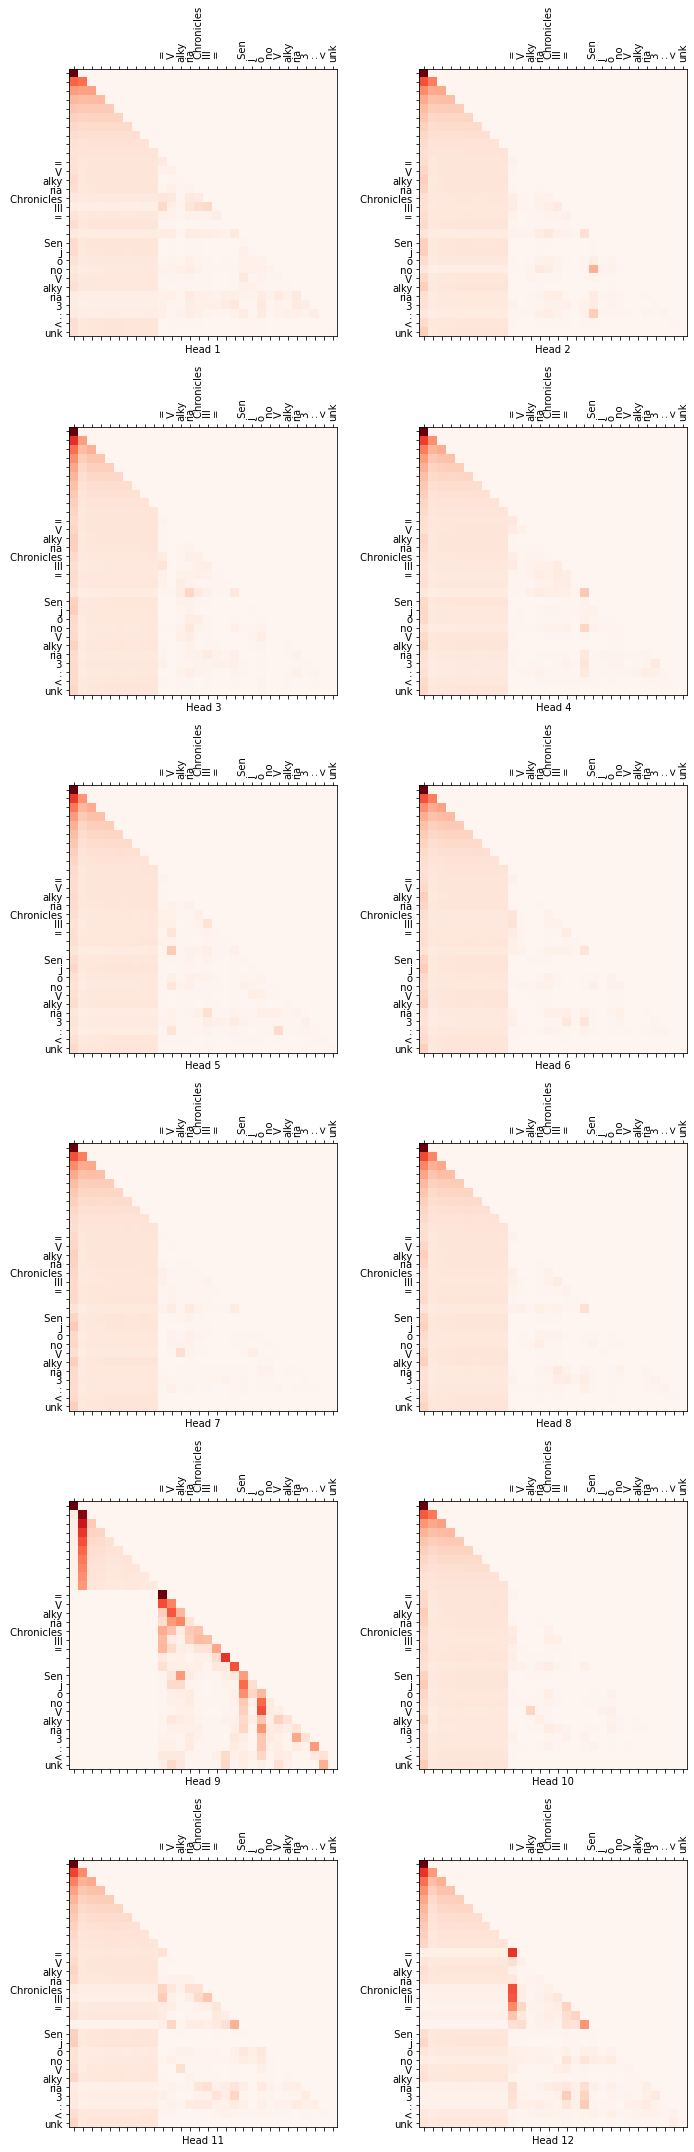

In [72]:
# seg 1
layer = -1
segment = 0
bn = 0
size = None

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions']

fn = f'img/rmt_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, size=size, p_attentions=None, filename=fn, save=False)

<Figure size 720x720 with 0 Axes>

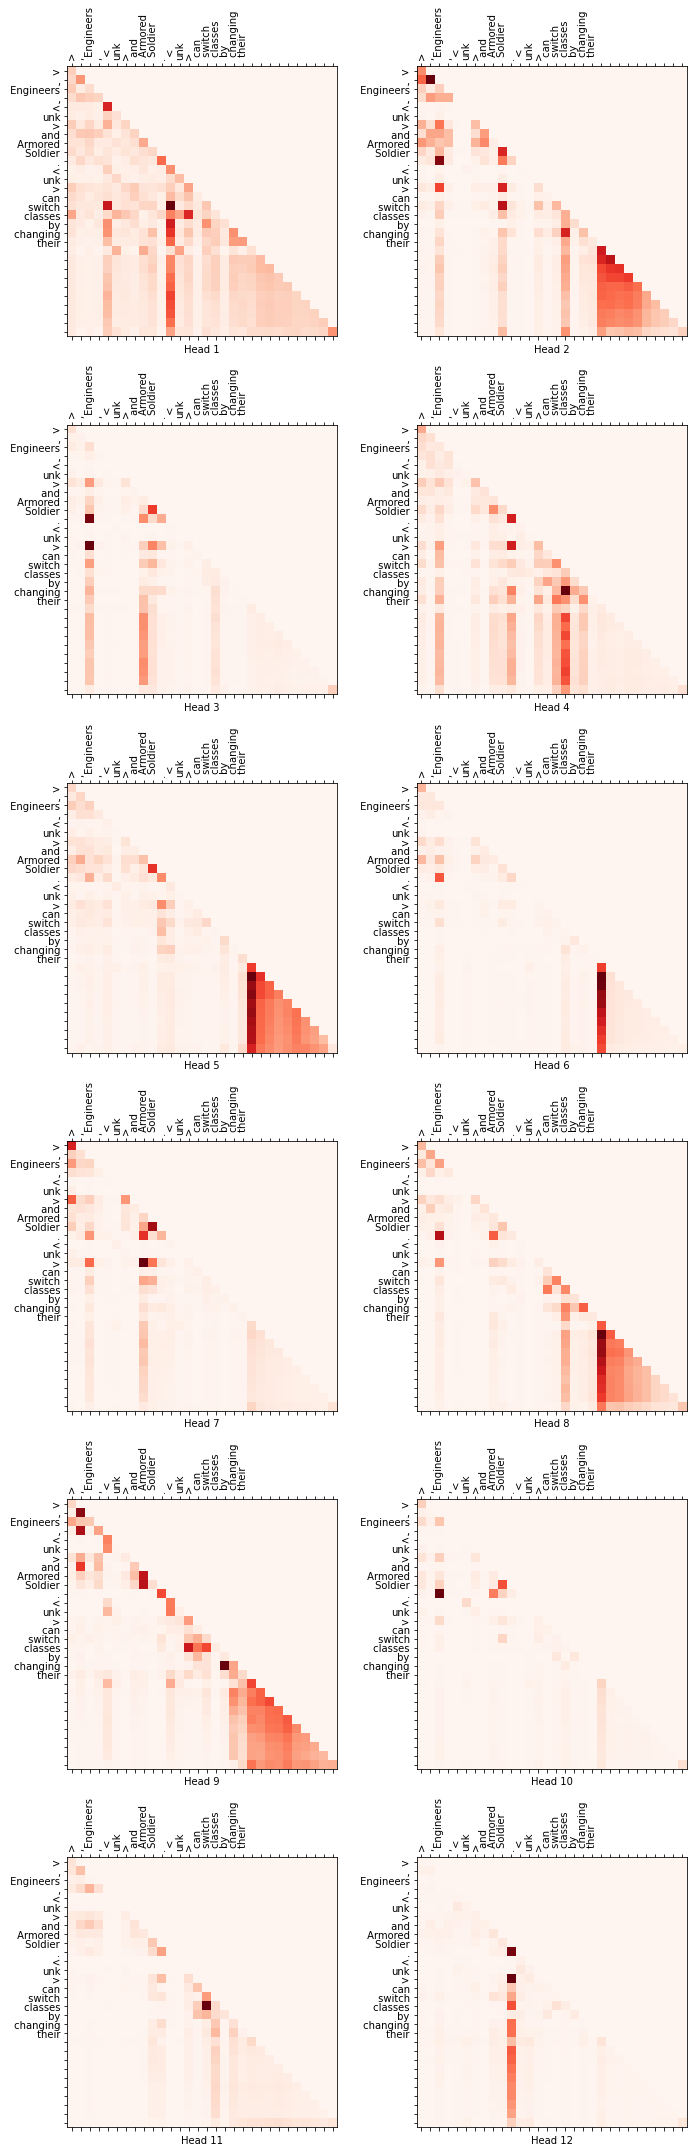

In [78]:
# seg 1
layer = -1
segment = 0
bn = 0
size = None

min_x, max_x = -30, 1025
min_y, max_y = -30, 1025


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]][min_x:max_x]
y_tokens = None#[tokenizer.decode([i]) for i in segmented[segment][bn]][min_y:max_y]
attentions = out[f'attentions']

fn = f'img/rmt_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=y_tokens, size=size, p_attentions=None, filename=fn, save=False)

In [69]:
# seg 1
layer = -1
segment = 0
bn = 0
size = 100

min_x, max_x = 0, 1025
min_y, max_y = 0, 1025


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions']

fn = f'img/rmt_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, size=size, p_attentions=None, filename=fn, save=False)

/tmp/ipykernel_2191087/2610704478.py:49: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2191087/2610704478.py:49: UserWarning: Glyph 12532 (\N{KATAKANA LETTER VU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2191087/2610704478.py:49: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2191087/2610704478.py:49: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2191087/2610704478.py:49: UserWarning: Glyph 12461 (\N{KATAKANA LETTER KI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2191087/2610704478.py:49: UserWarning: Glyph 12517 (\N{KATAKANA LETTER SMALL YU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2191087/2610704478.py:49: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2

<Figure size 7200x7200 with 0 Axes>

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12532 (\N{KATAKANA LETTER VU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12449 (\N{KATAKANA LETTER SMALL A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12461 (\N{KATAKANA L